# A Decay Model of American COVID Deaths

So in our previous foray into modeling American Coranvirus Deaths, we established that a model with a constant $p_{death}$ and $\lambda$ does not acuratley model the data. Now we will try again with a $p_{death}$ that decays to $0$ with time. But first I am going to import in the necessary libraries and some functions from the COVID_death_utils.py and Utils.py file, all these functions, we have already defined in the previous notebooks.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import stats
from matplotlib.widgets import Slider
import os

from Utils import *
USCases,GlobalCases,USDeaths,GlobalDeaths = get_data()

from COVID_death_utils import *

USdeltadeaths=get_delta(get_deaths(USDeaths,GlobalDeaths,'US'))
USdeltacases=get_delta(get_cases(USCases,GlobalCases,'US'))

FileNotFoundError: [WinError 2] The system cannot find the file specified: '/Utils'

Okay, now lets mathmatically define our new time decaying $p_{death}$:  $$p_{death}(t)=\frac{e^{-s\cdot t}}{1+e^{-p}}$$ where $t$ is the time (in days) from the first day of this model (1/23/20). As $t \rightarrow \infty$, $p_{death} \rightarrow 0$, this would make sense since new drugs, and improving medical methods should make $p_{death}$ decay to $0$.

In [2]:
class p_death_decay(object):
    def __init__(self,p_death_init,s_init,n):
        """
        p_death_init is the intial value of p_death at i=0
        s_init is the intial value of s
        n is the number of days that we would want to caculate this for
        """
        self.p=-np.log(1/p_death_init-1)
        self.s=s_init
        self.p_death=self.calculate_p_death(n)
        self.n=n
    def calculate_p_death(self,n):
        
        return np.exp(-self.s*np.arange(n))/(1+np.exp(-self.p))
    def get_p_death(self):
        return self.p_death
    def dp(self):
        return self.p_death*(1/(1+np.exp(self.p)))
    def ds(self):
        return -self.s*self.p_death
    
    def update_p(self, dloss,learning_rate):
        
        dp=self.dp()
        ds=self.ds()
        
        self.p-=learning_rate*np.mean(np.multiply(dloss,dp))
        self.s-=learning_rate*np.mean(np.multiply(dloss,ds))
        
        self.p_death=self.calculate_p_death(self.n)

Now, we can try again at modeling American COVID deaths, for now we will choose the loss function to be the absolute value loss function.

In [3]:
epoch_init=10
learning_rate_init=0.02
n=USdeltadeaths.shape[0]
p_death=p_death_decay(0.2,0.02,n)
L=Lambda_constant(6)
model1=model(USdeltacases,p_death,L)


for epoch in range(epoch_init):
    loss=Absolute_loss(model1.get_predicted_deaths(),USdeltadeaths)
    model1.update(loss, learning_rate_init)
    
    
model1.get_predicted_deaths()

%matplotlib notebook
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.margins(x=0)
    
plt.title('US deaths vs decay model, trained with absolute loss')
plt.ylabel('new deaths every day')
plt.grid()
    
x=np.arange(0,n,1)
r, =plt.plot(x,USdeltadeaths,c='k',label="actual new deaths")
p, =plt.plot(x,model1.get_predicted_deaths(),c='r',
                label="predicted new deaths")
plt.legend(loc='upper left')
ticks, dates= make_ticks('1/23/20',n_days=n, step=40)
plt.xticks(ticks, dates)

axepochs = plt.axes([0.25, 0.05, 0.65, 0.03])
slider_epochs=Slider(axepochs, "epochs",0,20,valinit=epoch_init,valstep=1)
                
axlearning_rate = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_learning_rate = Slider(axlearning_rate, "learning rate",0.001,0.1,
                              valinit=learning_rate_init,valstep=0.01)

def update(val):
    
    learning_rate=slider_learning_rate.val
    epochs = slider_epochs.val
    
    p_death=p_death_decay(0.2,0.02,n)
    L=Lambda_constant(6)
    model1=model(USdeltacases,p_death,L)
    epoch=0
    while epoch!=epochs:
        loss=Absolute_loss(model1.get_predicted_deaths(),USdeltadeaths)
        model1.update(loss, learning_rate)
        epoch+=1
        
    p.set_ydata(model1.get_predicted_deaths())
        
    fig.canvas.draw_idle()
    
slider_epochs.on_changed(update)
slider_learning_rate.on_changed(update)
plt.show()

NameError: name 'USdeltadeaths' is not defined

We can also try to first smooth out the new case and new death data by running it over a 7 day moving average. The reason I choose 7 days for now is because the new cases and deaths on sundays are often reported not as sunday's but monday's.

<IPython.core.display.Javascript object>


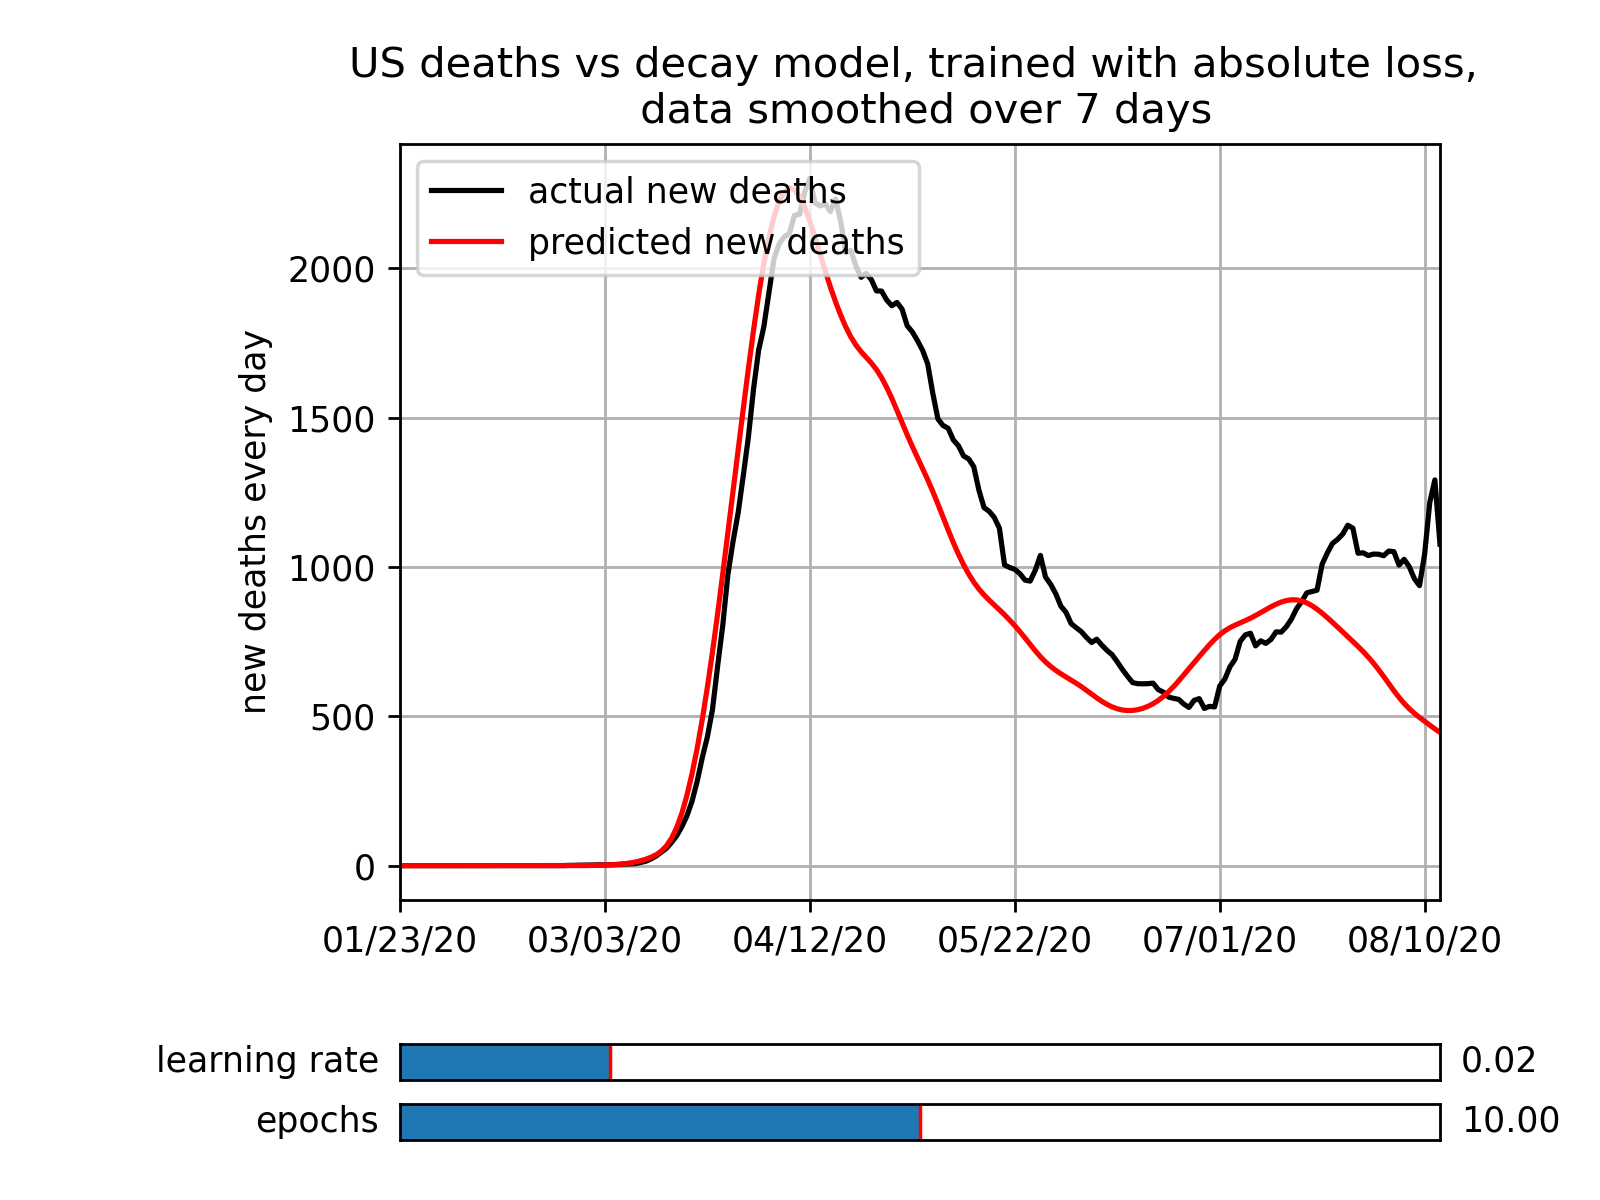

In [11]:
deltadeaths=moving_average(USdeltadeaths,7)
deltacases=moving_average(USdeltacases,7)

epoch_init=10
learning_rate_init=0.02
n=USdeltadeaths.shape[0]
p_death=p_death_decay(0.2,0.025,n)
L=Lambda_constant(6)
model1=model(deltacases,p_death,L)

for epoch in range(epoch_init):
    loss=Absolute_loss(model1.get_predicted_deaths(),deltadeaths)
    model1.update(loss, learning_rate_init)
    
    
model1.get_predicted_deaths()


fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.margins(x=0)
    
plt.title('US deaths vs decay model, trained with absolute loss, \n data smoothed over 7 days')
plt.ylabel('new deaths every day')
plt.grid()
    
x=np.arange(0,n,1)
r, =plt.plot(x,deltadeaths,c='k',label="actual new deaths")
p, =plt.plot(x,model1.get_predicted_deaths(),c='r',
                label="predicted new deaths")
plt.legend(loc='upper left')
ticks, dates= make_ticks('1/23/20',n_days=n,step=40)
plt.xticks(ticks, dates)

axepochs = plt.axes([0.25, 0.05, 0.65, 0.03])
slider_epochs=Slider(axepochs, "epochs",0,20,valinit=epoch_init,valstep=1)
                
axlearning_rate = plt.axes([0.25, 0.1, 0.65, 0.03])
slider_learning_rate = Slider(axlearning_rate, "learning rate",0.001,0.1,
                              valinit=learning_rate_init,valstep=0.01)

def update(val):
    
    learning_rate=slider_learning_rate.val
    epochs = slider_epochs.val
    
    p_death=p_death_decay(0.2,0.025,n)
    L=Lambda_constant(6)
    model1=model(deltacases,p_death,L)
    epoch=0
    while epoch!=epochs:
        loss=Absolute_loss(model1.get_predicted_deaths(),deltadeaths)
        model1.update(loss, learning_rate)
        epoch+=1
        
    p.set_ydata(model1.get_predicted_deaths())
        
    fig.canvas.draw_idle()
    
slider_epochs.on_changed(update)
slider_learning_rate.on_changed(update)
plt.show()

So as we can see, this model with a time decaying $p_{death}$ performs much better than one with $p_{death}$ as a constant. However, it does have a problem of $p_{death}$ dropping off to quickly, which explains how the new deaths tail of too quickly around 8/10/20. So, for the next step we will try again with a piecewise $p_{death}$